##### Copyright 2018 The TensorFlow Authors.

In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Neural Network from Scratch in TensorFlow Core

_Notebook orignially contributed by: [am1tyadav](https://github.com/am1tyadav)_

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github.com/tensorflow/examples/blob/master/community/en/neural_network_from_scratch_tensorflow_core.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/tree/master/community/en/neural_network_from_scratch_tensorflow_core.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview
In this notebook, we will create a Neural Network model from scratch to solve a Multi-Class Classification problem using TensorFlow Core. We are going to use the popular MNIST dataset (Grayscale images of hand-written digits from 0 to 9). 

If you already have some idea on how to create and train models using a high level API (like Keras) but want to dive a bit into the lower level code (TensorFlow Core), then this notebook would, hopefully, be useful to you. This notebook will expose you on how to use computational graphs in TensorFlow as we write the code for forward propagation and computing costs from scratch. Backward propagation and gradient computation is done automatically by TensorFlow.

## Setup
Let's start by importing the libraries and functions that we will need. The MNIST dataset is easily accessible from Keras. We will use the `to_categorical` helper function from Keras utilities to convert the labels to one-hot encoded representations.

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras.datasets import mnist
from tensorflow.python.keras.utils import to_categorical

## Defining a Class for the Neural Network

Next, let's define a class called `NNModel` for our neural network model. This class will encompass functionality typical to neural networks like forward propagation, computing costs and so on. After this class is ready, we will be able to use an instance of this class to simply call a method which will train the model on the training set and then return predictions on a given test set. When the class is initialized, we can pass on a list of number of nodes for the various layers including for the input and the output layers. All the layers are going to be densely connected. If, for example, we have 4 dimensional feature vectors, 3 output classes and want to use 2 hidden layers with 8 nodes each, we will pass on a list of number of nodes when instantiating the class like this:
```
layers = [4, 8, 8, 3]
model = NNModel(layers)
```

In [0]:
class NNModel():
  def __init__(self, layers):
    self.costs = [] # for storing in-training costs
    self.accuracies = [] # for storing in-training accuracies
    self.params = {} # for storing parameters W and b for various layers
    self.Z = {} # dictionary to store linear outputs
    self.A = {} # dictionary to store activation outputs
    self.layers = layers # a list of layers: each item is number of nodes
    self.L = len(layers) # total number of layers including input & output
    self.num_classes = layers[-1] # the last layer is the output layer
    self.num_features = layers[0] # the first layer is the input layer

## Initializing Parameters
We will use `tf.random_normal` to get random values from normal distribution for the weights of our network. The biases will be set to zeros. This gives us a starting point for figuring out the optimal values of the weights and the biases which best fit the dataset.

In [0]:
class NNModel(NNModel):
  def initialize_params(self):
    # initializing weights and biases for all the layers
    for layer in range(1, self.L):
      self.params['W' + str(layer)] = tf.Variable(
          tf.random_normal([self.layers[layer], self.layers[layer-1]]))
      self.params['b' + str(layer)] = tf.Variable(
          tf.zeros([self.layers[layer], 1]))

## Forward Propagation
To perform one step of forward propagation, we will define the function given below. One step means computing on one single batch of training examples. First, we compute the linear outputs:

\begin{equation}
Z = W.X+b
\end{equation}

Followed by computation of the activation outputs. In this model, we are only going to use the _relu_ activation function. Note that the output layer does not need to have this activation since we will apply _softmax_ to it as we plan to apply to the model to a classification problem. When the computations for all the layers are done, the final linear output is returned by this function.

In [0]:
class NNModel(NNModel):
  def forward_prop(self, x_batch):
    # compute linear and activation outputs for all the nodes
    self.A['0'] = tf.transpose(x_batch)
    for layer in range(1, self.L):
      self.Z[str(layer)] = tf.add(tf.matmul(self.params['W' + str(layer)],
          self.A[str(layer-1)]), self.params['b'+str(layer)])
      if layer != self.L - 1: # No activation is applied to the output layer
        self.A[str(layer)] = tf.nn.relu(self.Z[str(layer)])
    return tf.transpose(self.Z[str(self.L-1)])

## Computing Cost
The final linear output will be fed into a _softmax_ activation function and that will give us the probability scores for the output classes. We will use a function that TensorFlow provides to calculate the cross entropy loss given the final linear outputs and the labels. Cross entropy loss is simply indicative of the difference between the probability distribution of the given linear output and the probability distribution of the given labels in the dataset. Our function will return the computed cost back.

In [0]:
class NNModel(NNModel):
  def compute_cost(self, x_batch, y_batch):
    Z = self.forward_prop(x_batch)
    cost = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=Z, labels=y_batch))
    return cost

## Evaluating the Model
As we train the model, we may want to look at its performance on the training data. The cost computed in the previous step can be a good indicator. Another indicator could be the accuracy on the training set. We will write a function to calculate this accuracy and it will be used again after the training is complete to calculate accuracy of the model on the test set. We can use `tf.argmax` to find the classes with the highest probability score and compare it with the given labels.

In [0]:
class NNModel(NNModel):
  def evaluate(self, x_eval, y_eval, x, y):
    correct = tf.equal(tf.argmax(self.forward_prop(x), 1), tf.argmax(y, 1))
    acc = tf.reduce_mean(tf.cast(correct, 'float'))
    accuracy = acc.eval({x: x_eval, y: y_eval})
    return accuracy

## The Training Loop
Finally, we will write a function to run the training loop. This function will take arguments for the training set, the test set, number of epochs and batch size. We will first initialize the weights and biases, then create placeholders for the examples and labels to be used for forward propagation, computing costs and for evaluating the accuracies. We will use the _Adam Optimizer_ algorithm provided in TensorFlow.

The training loop itself needs to run within a TensorFlow session. In this loop, we will calculate costs for all the batches by running the optimizer to minimize the costs. After each epoch, cost for that epoch will be printed out along with the evaluated accuracy.

In [0]:
class NNModel(NNModel):
  def train(self, x_train, y_train, x_test, y_test, epochs, batch_size):
    self.initialize_params()
    m = x_train.shape[0]

    x = tf.placeholder('float', [None, self.num_features])
    y = tf.placeholder('float', [None, self.num_classes])

    cost = self.compute_cost(x, y)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      for epoch in range(epochs):
        epoch_cost = 0

        for batch in range(int(m / batch_size)):
          x_batch = x_train[(batch*batch_size):(batch*batch_size+batch_size)]
          y_batch = y_train[(batch*batch_size):(batch*batch_size+batch_size)]

          _, current_cost = sess.run([optimizer, cost],
              feed_dict={x: x_batch, y: y_batch})
          epoch_cost += current_cost

        self.costs.append(epoch_cost)
        accuracy = self.evaluate(x_train, y_train, x, y)
        self.accuracies.append(accuracy)
        print('Epoch {}/{}. Cost: {:.2f}. Accuracy: {:.2f}'.format(epoch,
            epochs, epoch_cost, accuracy))

      print('=================')
      print('Accuracy on test set: ', self.evaluate(x_test, y_test, x, y))
      # predictions
      z_pred = tf.argmax(self.forward_prop(x), 1)
      predictions = z_pred.eval({x: x_test})
    return predictions

## Processing the Dataset
Now that the `NNModel` class is complete, let's import the dataset. We will also convert the labels to their one-hot encoded representations, normalize the pixel values for all examples (You can also try normalizing by first subtracting the mean from all pixel values and then dividing by the total range of values but simply dividing by the total range also works well). Finally, we will reshape the examples on both the sets to unroll then from 28 by 28 arrays to 784 dimensional vectors.

In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_test_orig = x_test

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

x_train = x_train / 255.
x_test = x_test / 255.

x_train = np.float32(x_train)
x_train = np.reshape(x_train, (60000, 784))
x_test = np.float32(x_test)
x_test = np.reshape(x_test, (10000, 784))

## Training the Model

Now all we have to do is instantiate a model, pass in a list of layers with the number of units we want for each layer and call the `train()` method. We will need to pass the training set, the test set, number of epochs and the desired batch size.

In [0]:
EPOCHS = 10

model = NNModel([784, 256, 128, 10])

preds = model.train(x_train, y_train, x_test, y_test, EPOCHS, batch_size=128)

Instructions for updating:
Colocations handled automatically by placer.
Epoch 0/10. Cost: 86461.41. Accuracy: 0.83
Epoch 1/10. Cost: 17170.09. Accuracy: 0.88
Epoch 2/10. Cost: 11009.35. Accuracy: 0.91
Epoch 3/10. Cost: 7924.80. Accuracy: 0.92
Epoch 4/10. Cost: 5988.37. Accuracy: 0.93
Epoch 5/10. Cost: 4617.45. Accuracy: 0.94
Epoch 6/10. Cost: 3622.85. Accuracy: 0.95
Epoch 7/10. Cost: 2862.60. Accuracy: 0.96
Epoch 8/10. Cost: 2255.92. Accuracy: 0.96
Epoch 9/10. Cost: 1784.83. Accuracy: 0.97
Accuracy on test set:  0.9287


## Plotting the in-training Performance

Let's take a look at how the model performed during training in a couple of plots.

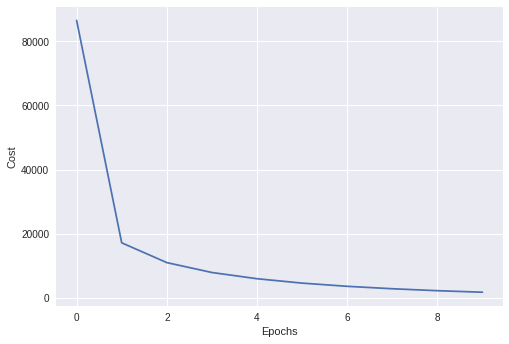

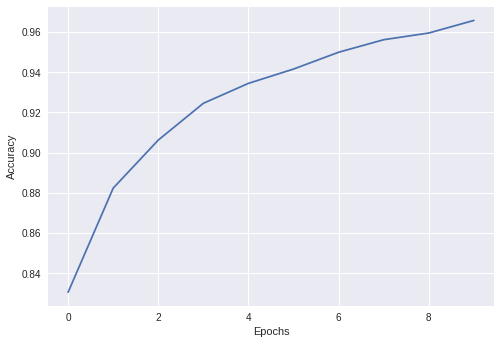

In [0]:
plt.plot(range(EPOCHS), model.costs)
plt.xlabel('Epochs')
plt.ylabel('Cost')
plt.show()

plt.plot(range(EPOCHS), model.accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

## Predictions

Finally, we will look at some of the predictions. The wrong predictions are labeled in red color.

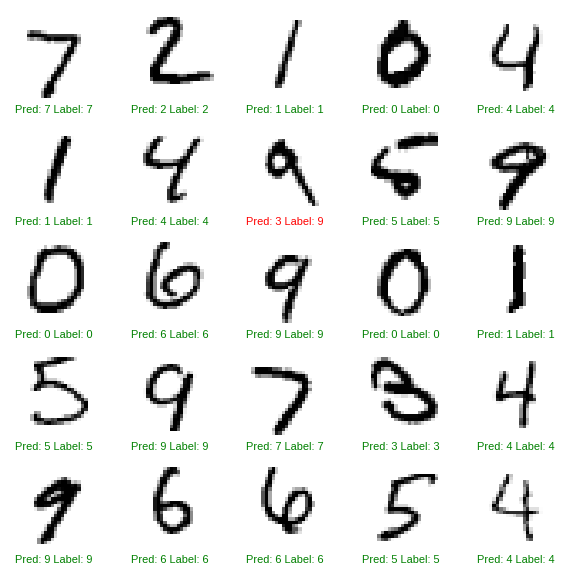

In [0]:
plt.figure(figsize=(10,10))

for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.imshow(x_test_orig[i], cmap='binary')
  plt.xticks([])
  plt.yticks([])
  pred = np.squeeze(preds[i])
  label = np.argmax(y_test[i])
  if pred == label:
    col = 'g'
  else:
    col = 'r'
  plt.xlabel('Pred: {} Label: {}'.format(pred, label), color=col)

plt.show()